In [1]:
import tensorflow as tf
from tensorflow import keras
import CO2_functions
import CO2_Processing
import pandas as pd
from CO2_functions import *
from CO2_Processing import *
import matplotlib.pyplot as plt
import pickle
import numpy as np
import sklearn
from sklearn import preprocessing
from sklearn.model_selection import GridSearchCV
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout
import os

Using TensorFlow backend.


In [2]:
import importlib
importlib.reload(CO2_functions)
importlib.reload(CO2_Processing)

from CO2_functions import *
from CO2_Processing import *

In [3]:
#Get the data from CHPC
data_orig = retrieve_data_from_folder('../CO2_Data_Final','2019-11-06','2019-11-06')

Retrieving data for 2019-11-06


In [4]:
data = remove_spikes(pd.read_pickle('Spike_ETs.pkl'),data_orig) #remove impulses to prevent skew
data = downsample_and_concatenate(data) #sample each instrument to its respective sampling rate such that everything is equally sampled after correcting DT
#data = sept24_26_correction(data) #add vent vel when not monitored (instrument off)
data = combine_vent_data(data,1) #Combine LI_Vent and Vent_Anem_Temp into a single df by sampling rate 
data['Vent_Mass'] = moving_mass_flow(data['Vent_Mass']) #Add the moving mass flow rate based on function developed. 

Concatenating Picarro Data
Concatenating Multi Data
setting night vent data to zero


In [10]:
#Processing for position 4
data['Vent_Mass'] = pd.concat([\
data['Vent_Mass'].loc[(data['Vent_Mass'].index>'2019-09-24 08:57:00')&(data['Vent_Mass'].index<'2019-09-26 08:00:00')],\
data['Vent_Mass'].loc[(data['Vent_Mass'].index>'2019-09-26 12:00:00')&(data['Vent_Mass'].index<'2019-10-03 13:00:00')].interpolate()])

In [3]:
#Processing for position 6
data_orig = retrieve_data_from_folder('../CO2_Data_Final','2019-11-06','2019-11-27')
data = remove_spikes(pd.read_pickle('Spike_ETs.pkl'),data_orig) #remove impulses to prevent skew
data = downsample_and_concatenate(data) #sample each instrument to its respective sampling rate such that everything is equally sampled after correcting DT
data = combine_vent_data(data,1) #Combine LI_Vent and Vent_Anem_Temp into a single df by sampling rate 
data['Vent_Mass'] = moving_mass_flow(data['Vent_Mass']) #Add the moving mass flow rate based on function developed. 
for key in data:
    data[key] = pd.concat([\
                               data[key].loc[(data[key].index>'2019-11-06 00:00:00')&(data[key].index<'2019-11-25 12:00:00')],\
                               data[key].loc[(data[key].index>'2019-11-25 17:00:00')&(data[key].index<'2019-11-27 10:28:00')]])


Retrieving data for 2019-11-06
Retrieving data for 2019-11-07
Retrieving data for 2019-11-08
Retrieving data for 2019-11-09
Retrieving data for 2019-11-10
Retrieving data for 2019-11-11
Retrieving data for 2019-11-12
Retrieving data for 2019-11-13
Retrieving data for 2019-11-14
Retrieving data for 2019-11-15
Retrieving data for 2019-11-16
Retrieving data for 2019-11-17
Retrieving data for 2019-11-18
Retrieving data for 2019-11-19
Retrieving data for 2019-11-20
Retrieving data for 2019-11-21
Retrieving data for 2019-11-22
Retrieving data for 2019-11-23
Retrieving data for 2019-11-24
Retrieving data for 2019-11-25
Retrieving data for 2019-11-26
Retrieving data for 2019-11-27
Concatenating Picarro Data
Concatenating Multi Data
setting night vent data to zero


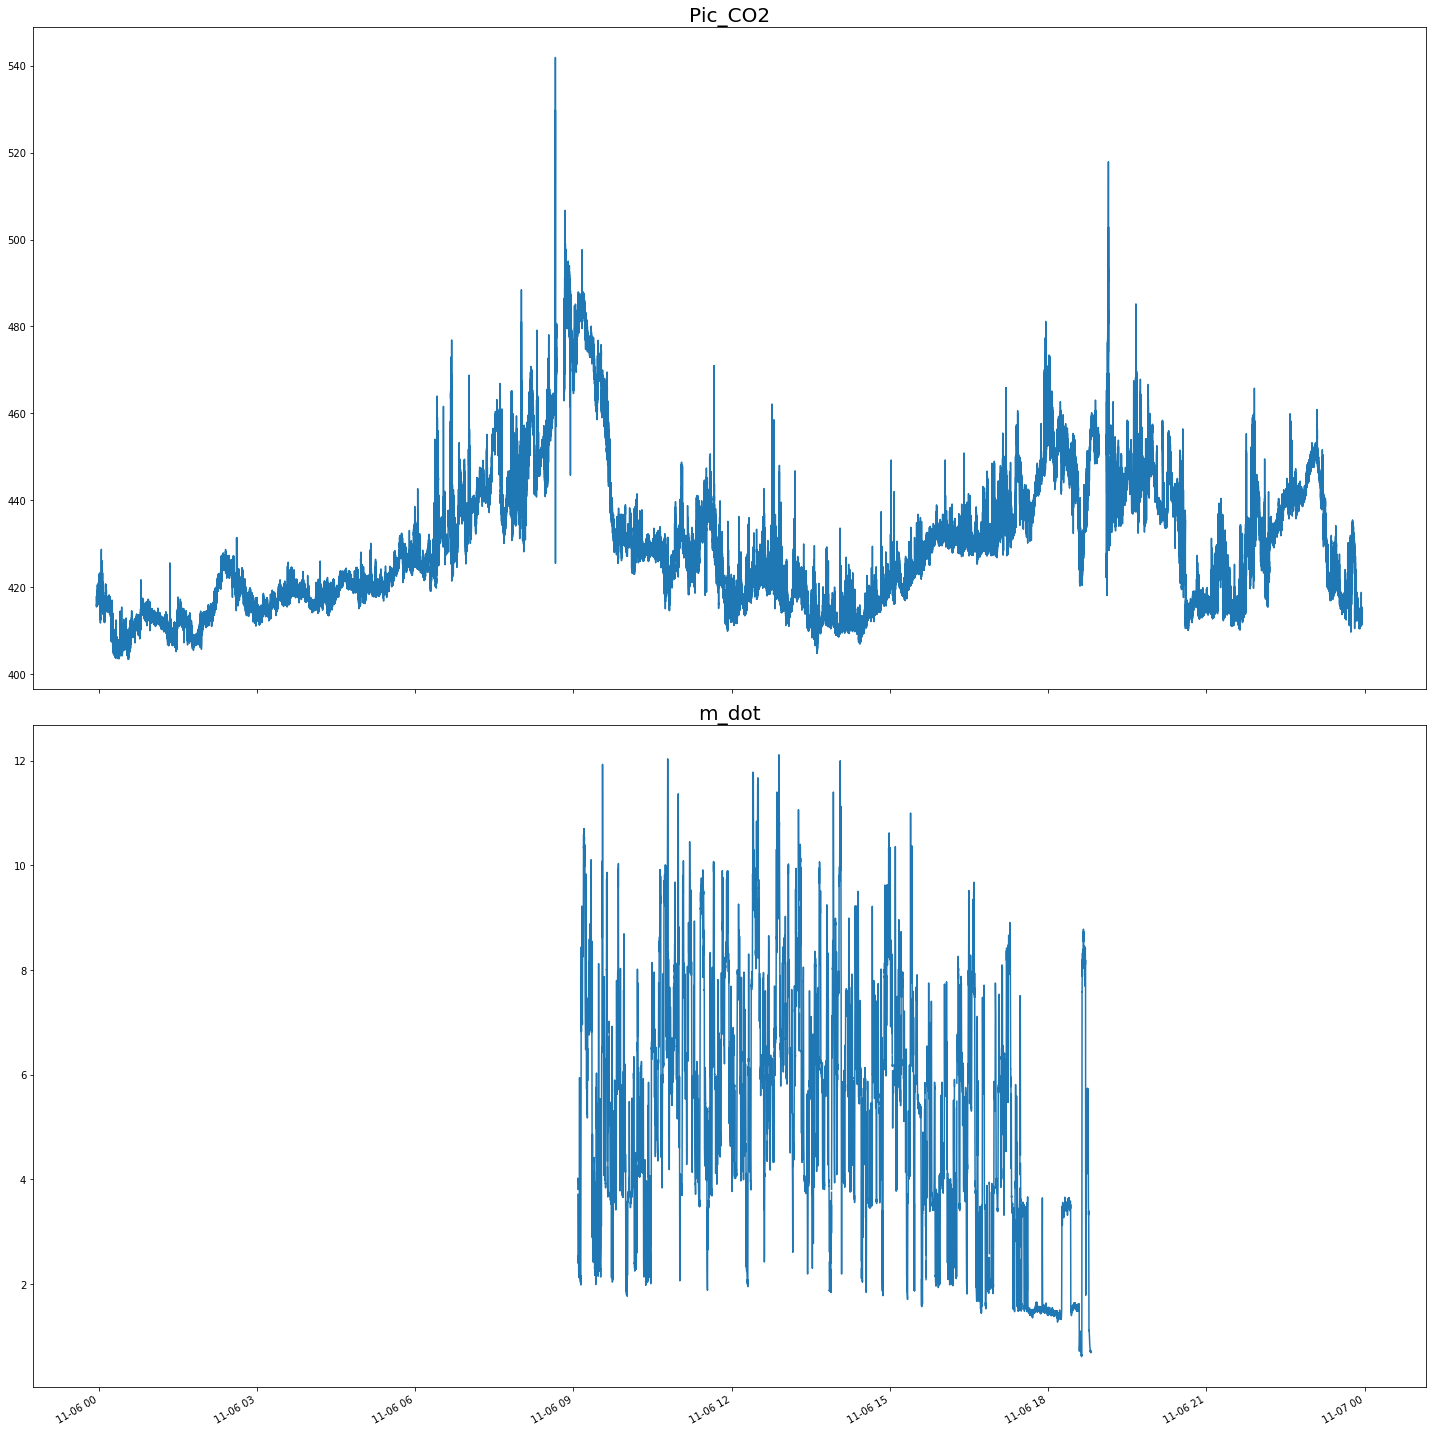

Is this an acceptable range? y


In [5]:
#Clip the picarro and vent_mass data frames to a specific region of interest
pic,vent = plot_refinement_all([[data['Picarro'],'Corrected_DT','Pic_CO2'],\
                                [data['Vent_Mass'],'Corrected_DT','m_dot']],\
                               'separate')

In [6]:
#Apply a moving average and downsample
#Numbers of seconds
pic_proc = dwn_sample(pic,1)
vent_proc = dwn_sample(vent,1)

Downsampling by mean at 1 seconds
Downsampling by mean at 1 seconds


In [7]:
#Concatenate and add wind speed & direction
df = pd.concat([pic_proc,vent_proc],axis=1)
df = wind_add(df,'ANEM_X','ANEM_Y')

Adding Wind Direction as 'wd'
Adding Wind Speed as 'ws'


In [8]:
cols = ['Pic_CO2', 'ANEM_Y', 'ANEM_X', 'ANEM_Z', 'm_dot', 'wd', 'ws']

In [9]:
df = df[cols]

In [10]:
df

,Pic_CO2,ANEM_Y,ANEM_X,ANEM_Z,m_dot,wd,ws
Corrected_DT,,,,,,,
2019-11-05 23:57:29,417.355873,NaN,NaN,NaN,NaN,NaN,NaN
2019-11-05 23:57:30,416.904681,NaN,NaN,NaN,NaN,NaN,NaN
2019-11-05 23:57:31,416.813753,NaN,NaN,NaN,NaN,NaN,NaN
2019-11-05 23:57:32,416.667225,-0.207220,-0.745120,-0.026776,NaN,74.458601,1.053758
2019-11-05 23:57:33,416.052170,-0.191319,-0.741699,-0.070518,NaN,75.536024,1.048921
...,...,...,...,...,...,...,...
2019-11-06 23:59:46,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2019-11-06 23:59:47,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2019-11-06 23:59:48,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [11]:
#Make mass flux the last column
loc = df.columns.get_loc('m_dot')

cols = df.columns.tolist()
cols = cols[0:loc]+cols[(loc+1):]+[cols[loc]]
df = df[cols]

In [12]:
#SET UP TIME LAGGING FUNTION
#Courtesy of Jason Brownlee
#https://machinelearningmastery.com/multivariate-time-series-forecasting-lstms-keras/
from pandas import DataFrame
from pandas import concat
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    """
    Frame a time series as a supervised learning dataset.
    Arguments:
    data: Sequence of observations as a list or NumPy array.
    n_in: Number of lag observations as input (X).
    n_out: Number of observations as output (y).
    dropnan: Boolean whether or not to drop rows with NaN values.
    Returns:
    Pandas DataFrame of series framed for supervised learning.
    """
    n_vars = 1 if type(data) is list else data.shape[1]
    df = DataFrame(data)
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('%s(t-%d)' % (df.columns[j], i)) for j in range(n_vars)]
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('%s(t)' % (df.columns[j])) for j in range(n_vars)]
        else:
            names += [('%s(t+%d)' % (df.columns[j], i)) for j in range(n_vars)]
    # put it all together
    agg = concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg

In [13]:
#We need to delete some of the columns generated by the series_to_supervised function
def delete_unwanted_cols(initial_lagged_df):
    #We want to delete all of the values of LI_CO2 EXCEPT the t=t case (very last one)
    s = "m_dot" 
    drop_cols = [] #initialize columns to be dropped
    for column in initial_lagged_df:
#         if s not in column and "(t)" in column:
#             drop_cols.append(column)     #Drop all columns except the LI_CO2 column at time t (only want the lagged variables)
        if s in column and "(t)" not in column:
            drop_cols.append(column)     #Drop all columns with LI_CO2 that arent the last one
    return initial_lagged_df.drop(drop_cols,axis = 1)  

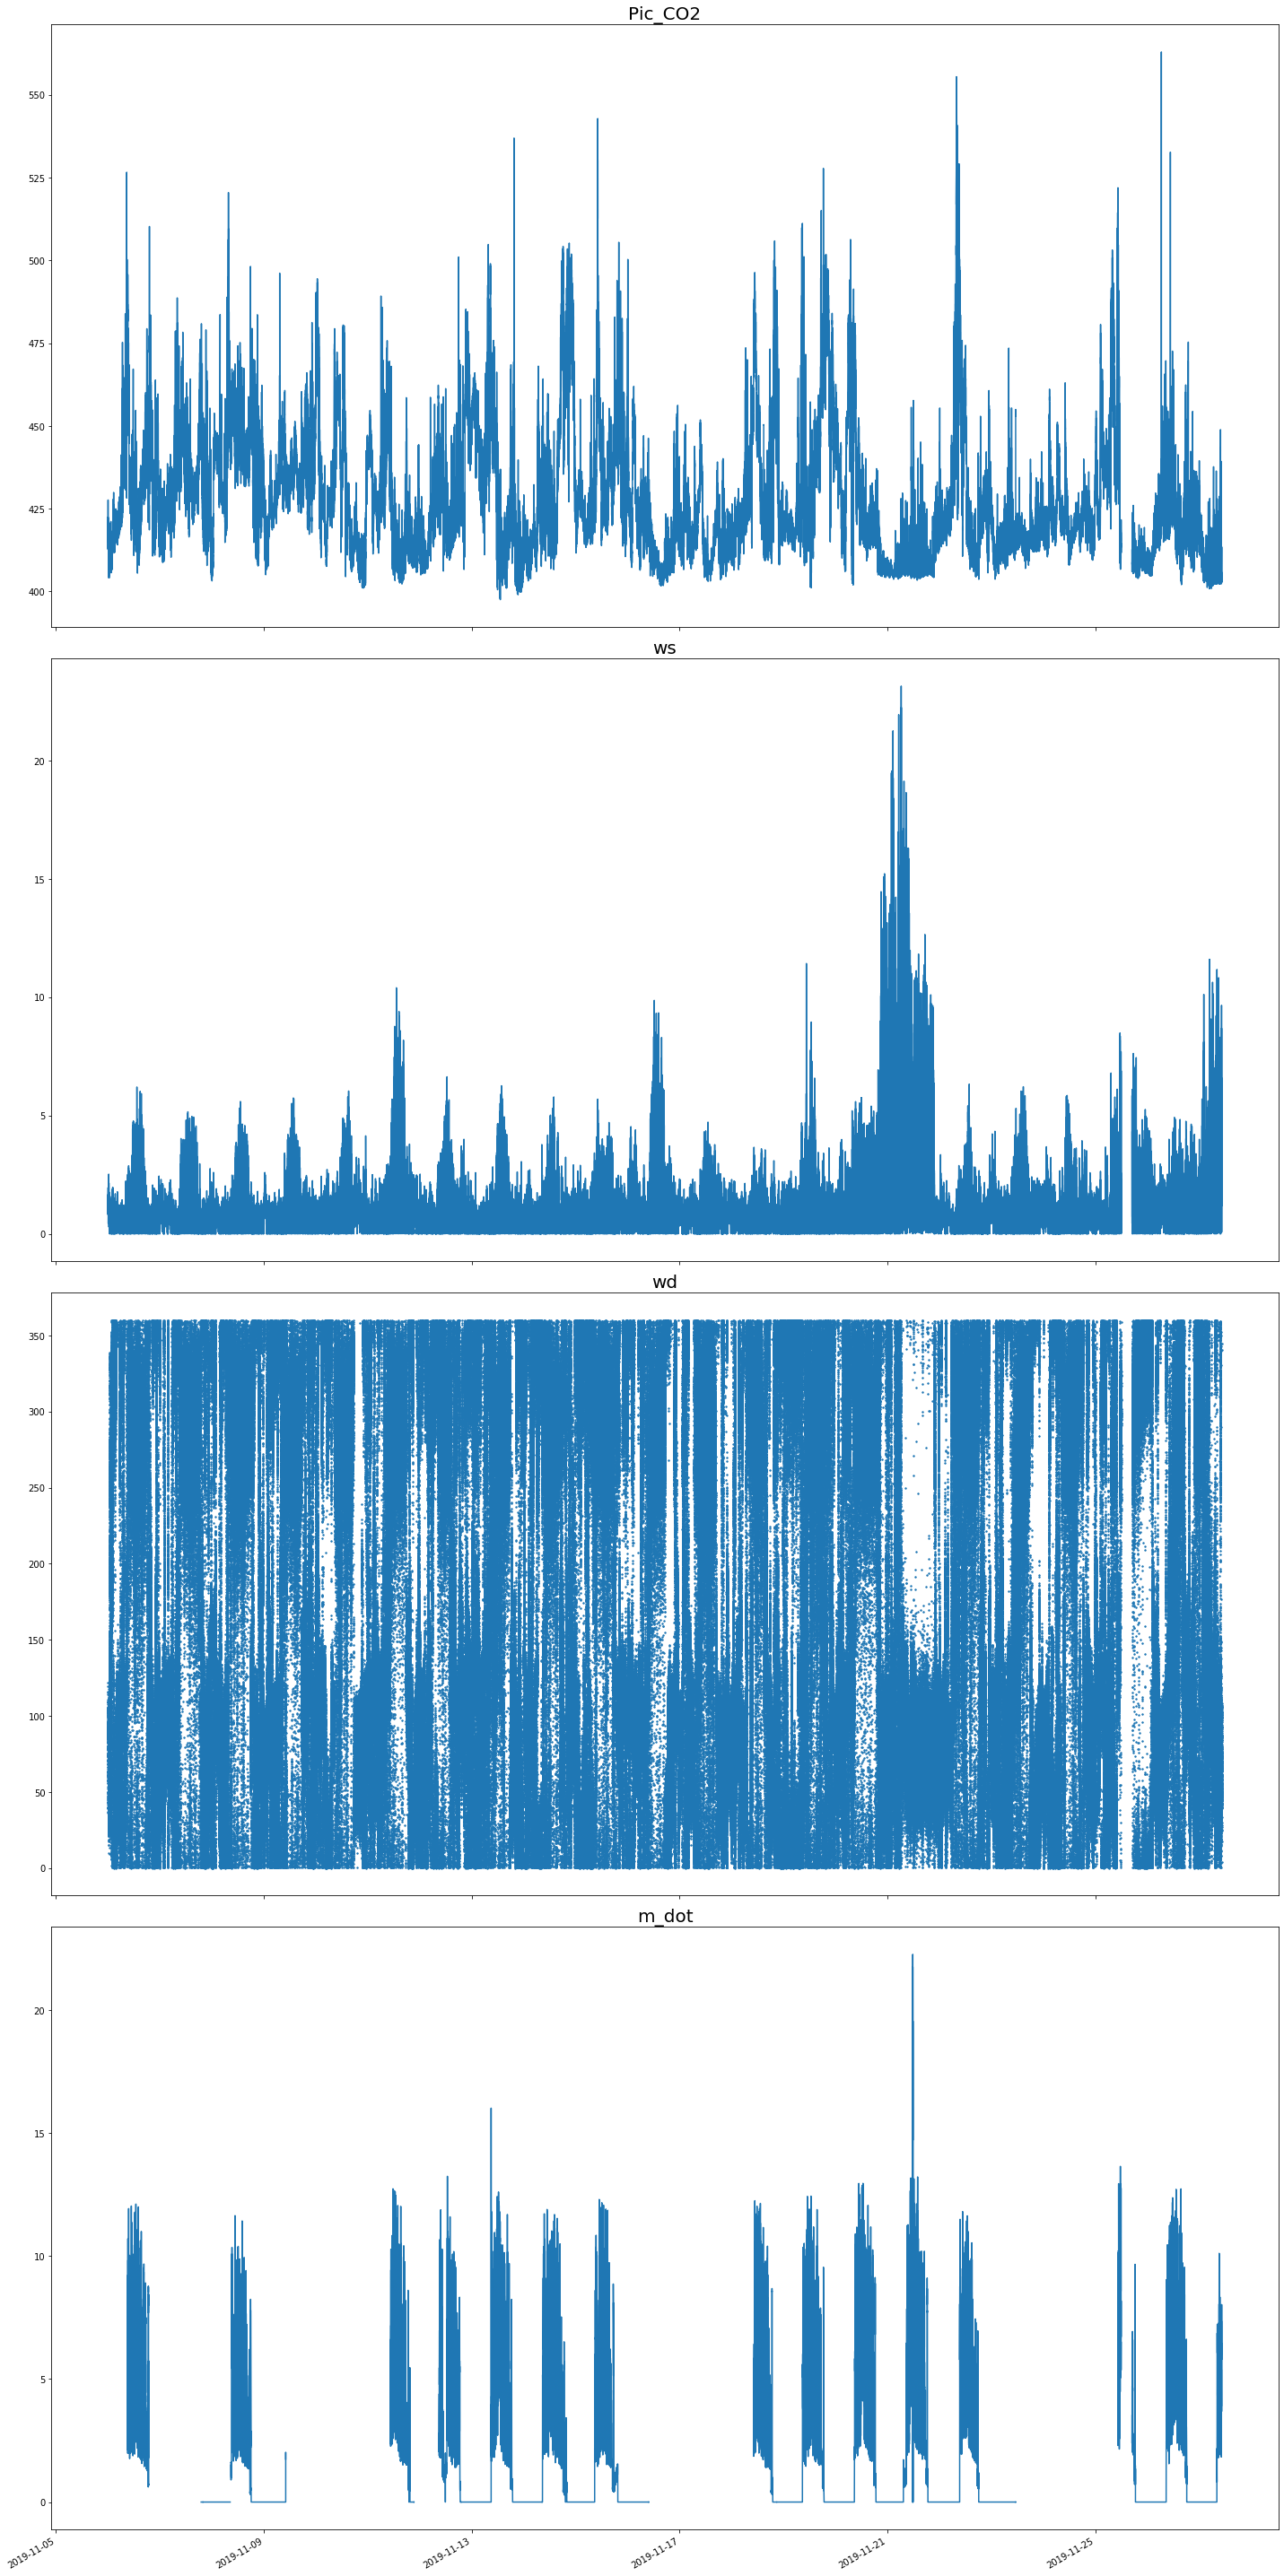

Is this an acceptable range? y


[               Corrected_DT     Pic_CO2    ANEM_Y    ANEM_X    ANEM_Z  \
 0       2019-11-06 00:00:00  419.820335 -0.152936 -0.722057 -0.108604   
 1       2019-11-06 00:00:01  419.844468 -0.149635 -0.678063 -0.136613   
 2       2019-11-06 00:00:02  420.073711 -0.169514 -0.661799 -0.092542   
 3       2019-11-06 00:00:03  419.716628 -0.184727 -0.690047 -0.090759   
 4       2019-11-06 00:00:04  420.013121 -0.226239 -0.775958 -0.113106   
 ...                     ...         ...       ...       ...       ...   
 1852075 2019-11-27 10:27:55  408.729880 -0.775239 -3.359694 -0.110396   
 1852076 2019-11-27 10:27:56  413.454666 -1.324857 -3.622167 -0.689007   
 1852077 2019-11-27 10:27:57  404.631278 -1.203595 -3.103868 -0.132455   
 1852078 2019-11-27 10:27:58  404.267877 -1.985989 -3.116479  0.116325   
 1852079 2019-11-27 10:27:59  403.868190 -2.535886 -3.693327 -0.927112   
 
                 wd        ws     m_dot  
 0        78.041146  1.021143       NaN  
 1        77.555445  0.958

In [31]:
plot_refinement_all([[df,'Corrected_DT','Pic_CO2'],[df,'Corrected_DT','ws'],[df,'Corrected_DT','wd'],[df,'Corrected_DT','m_dot']],'separate')

In [14]:
#TIME LAG
df_to_use = df

n_seconds = 10 #how many periods to lag
n_features= len(df_to_use.columns)-1 #how many features exist in the feature matrix (number of cols - target col)
time_lagged = series_to_supervised(df_to_use,n_in=0,n_out=n_seconds,dropnan=False) #lag function
time_lagged_reframed = delete_unwanted_cols(time_lagged) #delete unneccesary columns


#Make mass flux at t the last column
loc = time_lagged_reframed.columns.get_loc('m_dot(t)')

cols = time_lagged_reframed.columns.tolist()
cols = cols[0:loc]+cols[(loc+1):]+[cols[loc]]
time_lagged_reframed = time_lagged_reframed[cols]


#cols = list(time_lagged_reframed.columns)
#cols = cols[1:] + [cols[0]]
#time_lagged_reframed = time_lagged_reframed[cols]
time_lagged_reframed

,Pic_CO2(t),ANEM_Y(t),ANEM_X(t),ANEM_Z(t),wd(t),ws(t),Pic_CO2(t+1),ANEM_Y(t+1),ANEM_X(t+1),ANEM_Z(t+1),...,ANEM_Z(t+8),wd(t+8),ws(t+8),Pic_CO2(t+9),ANEM_Y(t+9),ANEM_X(t+9),ANEM_Z(t+9),wd(t+9),ws(t+9),m_dot(t)
Corrected_DT,,,,,,,,,,,,,,,,,,,,,
2019-11-05 23:57:29,417.355873,NaN,NaN,NaN,NaN,NaN,416.904681,NaN,NaN,NaN,...,-0.088913,60.306698,1.077447,416.613484,-0.446669,-0.783966,-0.198851,60.327436,1.108695,NaN
2019-11-05 23:57:30,416.904681,NaN,NaN,NaN,NaN,NaN,416.813753,NaN,NaN,NaN,...,-0.198851,60.327436,1.108695,416.633728,-0.446094,-0.775359,-0.213702,60.086498,1.096524,NaN
2019-11-05 23:57:31,416.813753,NaN,NaN,NaN,NaN,NaN,416.667225,-0.207220,-0.745120,-0.026776,...,-0.213702,60.086498,1.096524,416.696930,-0.329521,-0.767607,-0.234447,66.766947,1.085560,NaN
2019-11-05 23:57:32,416.667225,-0.207220,-0.745120,-0.026776,74.458601,1.053758,416.052170,-0.191319,-0.741699,-0.070518,...,-0.234447,66.766947,1.085560,416.689863,-0.238964,-0.677347,-0.181632,70.567474,0.957913,NaN
2019-11-05 23:57:33,416.052170,-0.191319,-0.741699,-0.070518,75.536024,1.048921,416.330615,-0.239567,-0.703026,-0.088271,...,-0.181632,70.567474,0.957913,416.529512,-0.263472,-0.566997,-0.120731,65.076646,0.801856,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-11-06 23:59:46,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2019-11-06 23:59:47,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2019-11-06 23:59:48,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


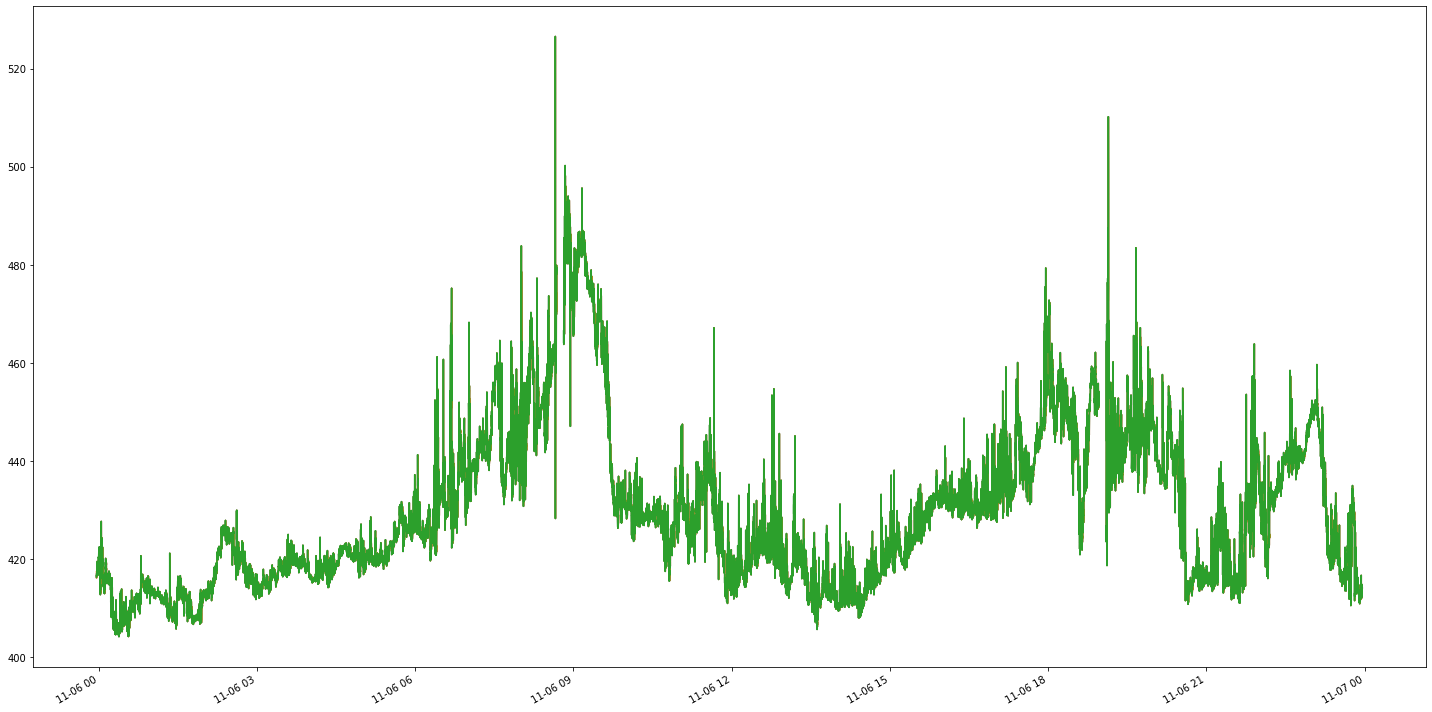

Is this an acceptable range? y


[             Corrected_DT  Pic_CO2(t)  ANEM_Y(t)  ANEM_X(t)  ANEM_Z(t)  \
 0     2019-11-05 23:57:29  417.355873        NaN        NaN        NaN   
 1     2019-11-05 23:57:30  416.904681        NaN        NaN        NaN   
 2     2019-11-05 23:57:31  416.813753        NaN        NaN        NaN   
 3     2019-11-05 23:57:32  416.667225  -0.207220  -0.745120  -0.026776   
 4     2019-11-05 23:57:33  416.052170  -0.191319  -0.741699  -0.070518   
 ...                   ...         ...        ...        ...        ...   
 86537 2019-11-06 23:59:46         NaN        NaN        NaN        NaN   
 86538 2019-11-06 23:59:47         NaN        NaN        NaN        NaN   
 86539 2019-11-06 23:59:48         NaN        NaN        NaN        NaN   
 86540 2019-11-06 23:59:49         NaN        NaN        NaN        NaN   
 86541 2019-11-06 23:59:50         NaN        NaN        NaN        NaN   
 
            wd(t)     ws(t)  m_dot(t)  Pic_CO2(t+1)  ANEM_Y(t+1)  ...  \
 0            NaN       N

In [19]:
plot_refinement_all([[time_lagged,'Corrected_DT','Pic_CO2(t+1)'],[df,'Corrected_DT','Pic_CO2'],[time_lagged_reframed,'Corrected_DT','Pic_CO2(t+6)']],'stack')

In [15]:
values = time_lagged_reframed.dropna().values #Convert to numpy for processing
min_max_scalar = preprocessing.MinMaxScaler() #setup scaling
values_scaled = min_max_scalar.fit_transform(values) #scale all values from 0 to 1

In [16]:
len(df)

86542

In [17]:
#Set train size. Because time is a factor, we do not choose randomly, but chronologically
percent_train = 0.6
train_size = int(len(values)*percent_train) 

In [18]:
train = values_scaled[:train_size,:]  #Get train/test arrays
test = values_scaled[train_size:,:]

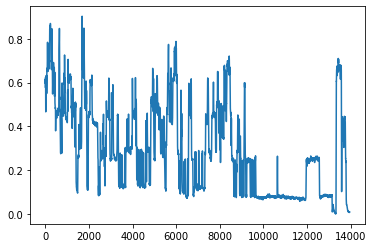

In [19]:
plt.plot(test[:,60])

In [20]:
X_train,y_train = train[:,:-1], train[:,-1] #Get feature/target arrays
X_test, y_test = test[:,:-1], test[:,-1]

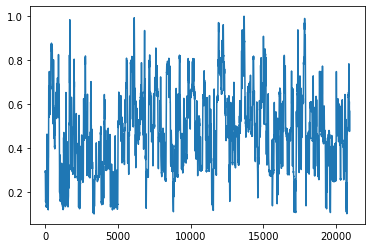

In [21]:
plt.plot(y_train[:])

In [22]:
X_train = X_train.reshape((X_train.shape[0], n_seconds, n_features)) 
X_test = X_test.reshape((X_test.shape[0], n_seconds, n_features))
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

(20925, 10, 6) (20925,) (13950, 10, 6) (13950,)


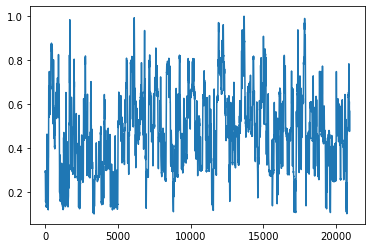

In [23]:
plt.plot(y_train[:])

In [24]:
#Gridsearch

from sklearn.model_selection import GridSearchCV
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout


from keras.wrappers.scikit_learn import KerasClassifier

def create_model():
    model = Sequential()
    model.add(LSTM(128,activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(1))
    
    model.compile(loss='mse',optimizer='adam',metrics=['accuracy'])
    
    return model

model = KerasClassifier(build_fn=create_model,verbose=10)

batch_size = [5,10,20,50,100]
epochs = [1,5,10,20,50]

param_grid = dict(batch_size=batch_size, epochs=epochs)
grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=-1, cv=3,verbose=10)
grid_result = grid.fit(X_train, y_train,verbose=False)

print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Fitting 3 folds for each of 25 candidates, totalling 75 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 56 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of  75 | elapsed:    3.2s remaining:   57.3s
[Parallel(n_jobs=-1)]: Done  12 out of  75 | elapsed:    3.2s remaining:   16.9s
[Parallel(n_jobs=-1)]: Done  20 out of  75 | elapsed:    3.2s remaining:    8.9s
[Parallel(n_jobs=-1)]: Done  28 out of  75 | elapsed:    3.2s remaining:    5.4s
[Parallel(n_jobs=-1)]: Done  36 out of  75 | elapsed:    3.2s remaining:    3.5s
[Parallel(n_jobs=-1)]: Done  44 out of  75 | elapsed:    3.2s remaining:    2.3s
[Parallel(n_jobs=-1)]: Done  52 out of  75 | elapsed:    3.2s remaining:    1.4s
[Parallel(n_jobs=-1)]: Done  60 out of  75 | elapsed:    3.2s remaining:    0.8s
[Parallel(n_jobs=-1)]: Done  68 out of  75 | elapsed:    3.2s remaining:    0.3s


KeyboardInterrupt: 

In [25]:
#Train Model
model = Sequential()
model.add(LSTM(128,activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(1))
opt = tf.keras.optimizers.Adam(lr=1e-3,decay=1e-5)

model.compile(loss='mse',optimizer=opt,metrics=['accuracy'])
history = model.fit(X_train,y_train,epochs=1,batch_size=10,validation_data=(X_test,y_test))

Train on 20925 samples, validate on 13950 samples
Epoch 1/1
20925/20925 [==============================] - 77s 4ms/step - loss: 0.0370 - accuracy: 0.0000e+00 - val_loss: 0.0541 - val_accuracy: 7.1685e-05


In [36]:

os.listdir()

['.git',
 '.gitignore',
 'All_actualET_Spikes.csv',
 'All_actualET_Spikes.pkl',
 'Direction_Tester.ipynb',
 'Drift_Correct.ipynb',
 'Mass_Flux.ipynb',
 'README.md',
 'Smoothing.ipynb',
 'Spike_ETs.pkl',
 'Spike_Finder.ipynb',
 'Time_Series_Averaging.ipynb',
 'environment.yml',
 '.ipynb_checkpoints',
 '__pycache__',
 'Data_Viewer.ipynb',
 'SQL_download.py',
 'CO2_Processing.py',
 'ML.ipynb',
 'batch_download.sh',
 'CO2_functions.py',
 'batch_ML_trainer.sh',
 'ML_trainer.py',
 'batch_gridsearch.sh',
 'gridsearch.py',
 'ML_Models',
 'Slurm_Reports',
 'Multiplexer_Testing.ipynb']

In [27]:
#Write out model
with open('/ML_Models', 'wb') as file_pi:
    pickle.dump(history.history, file_pi)
# from keras.models import model_from_json
# model_json = model.to_json()
# with open("model1.json", "w") as json_file:
#     json_file.write(model_json)
# model.save_weights("model1.h5")
print("Saved model to disk")

OSError: [Errno 30] Read-only file system: '/ML_Models'

In [2]:
#Read in model
from keras.models import model_from_json

json_file = open('ML_Models/PN6BS20E10.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)

loaded_model.load_weights("ML_Models/PN6BS20E10.h5")
print("Loaded model from disk")

Loaded model from disk


In [3]:
#Get train/test
X_train,X_test,y_train,y_test,min_max_scalar = process_for_ML_test(['Pic_CO2','ANEM_X','ANEM_Y','ANEM_Z','wd','ws'],15,6)

position number = 6
Retrieving data for 2019-11-06
Retrieving data for 2019-11-07
Retrieving data for 2019-11-08
Retrieving data for 2019-11-09
Retrieving data for 2019-11-10
Retrieving data for 2019-11-11
Retrieving data for 2019-11-12
Retrieving data for 2019-11-13
Retrieving data for 2019-11-14
Retrieving data for 2019-11-15
Retrieving data for 2019-11-16
Retrieving data for 2019-11-17
Retrieving data for 2019-11-18
Retrieving data for 2019-11-19
Retrieving data for 2019-11-20
Retrieving data for 2019-11-21
Retrieving data for 2019-11-22
Retrieving data for 2019-11-23
Retrieving data for 2019-11-24
Retrieving data for 2019-11-25
Retrieving data for 2019-11-26
Retrieving data for 2019-11-27
Concatenating Picarro Data
Concatenating Multi Data
setting night vent data to zero
Downsampling by mean at 1 seconds
Downsampling by mean at 1 seconds
Adding Wind Direction as 'wd'
Adding Wind Speed as 'ws'
columns fed to numpy:  Index(['Pic_CO2(t)', 'ANEM_X(t)', 'ANEM_Y(t)', 'ANEM_Z(t)', 'wd(t)'

In [6]:
yfit = loaded_model.predict(X_test) #fit to x_test

In [4]:
loaded_model.history

AttributeError: 'Sequential' object has no attribute 'history'

In [11]:
X_test_original_shape = X_test.reshape(457023, 60)
y_test_original_shape = y_test.reshape(457023,)
merged_tests = np.concatenate((X_test_original_shape,y_test_original_shape[:,None]),axis=1)
unscaled = pd.DataFrame(min_max_scalar.inverse_transform(merged_tests))

unscaled.columns = ['Pic_CO2(t)', 'ANEM_X(t)', 'ANEM_Y(t)', 'ANEM_Z(t)', 'wd(t)', 'ws(t)',
       'Pic_CO2(t+1)', 'ANEM_X(t+1)', 'ANEM_Y(t+1)', 'ANEM_Z(t+1)', 'wd(t+1)',
       'ws(t+1)', 'Pic_CO2(t+2)', 'ANEM_X(t+2)', 'ANEM_Y(t+2)', 'ANEM_Z(t+2)',
       'wd(t+2)', 'ws(t+2)', 'Pic_CO2(t+3)', 'ANEM_X(t+3)', 'ANEM_Y(t+3)',
       'ANEM_Z(t+3)', 'wd(t+3)', 'ws(t+3)', 'Pic_CO2(t+4)', 'ANEM_X(t+4)',
       'ANEM_Y(t+4)', 'ANEM_Z(t+4)', 'wd(t+4)', 'ws(t+4)', 'Pic_CO2(t+5)',
       'ANEM_X(t+5)', 'ANEM_Y(t+5)', 'ANEM_Z(t+5)', 'wd(t+5)', 'ws(t+5)',
       'Pic_CO2(t+6)', 'ANEM_X(t+6)', 'ANEM_Y(t+6)', 'ANEM_Z(t+6)', 'wd(t+6)',
       'ws(t+6)', 'Pic_CO2(t+7)', 'ANEM_X(t+7)', 'ANEM_Y(t+7)', 'ANEM_Z(t+7)',
       'wd(t+7)', 'ws(t+7)', 'Pic_CO2(t+8)', 'ANEM_X(t+8)', 'ANEM_Y(t+8)',
       'ANEM_Z(t+8)', 'wd(t+8)', 'ws(t+8)', 'Pic_CO2(t+9)', 'ANEM_X(t+9)',
       'ANEM_Y(t+9)', 'ANEM_Z(t+9)', 'wd(t+9)', 'ws(t+9)', 'm_dot(t)_test']

In [12]:
keep_col = ['m_dot(t)_test']
unscaled = unscaled[keep_col]

In [13]:
y_fit_original_shape = yfit.reshape(457023,)
merged_tests = np.concatenate((X_test_original_shape,y_fit_original_shape[:,None]),axis=1)
unscaled1 = pd.DataFrame(min_max_scalar.inverse_transform(merged_tests))

unscaled1.columns = ['Pic_CO2(t)', 'ANEM_X(t)', 'ANEM_Y(t)', 'ANEM_Z(t)', 'wd(t)', 'ws(t)',
       'Pic_CO2(t+1)', 'ANEM_X(t+1)', 'ANEM_Y(t+1)', 'ANEM_Z(t+1)', 'wd(t+1)',
       'ws(t+1)', 'Pic_CO2(t+2)', 'ANEM_X(t+2)', 'ANEM_Y(t+2)', 'ANEM_Z(t+2)',
       'wd(t+2)', 'ws(t+2)', 'Pic_CO2(t+3)', 'ANEM_X(t+3)', 'ANEM_Y(t+3)',
       'ANEM_Z(t+3)', 'wd(t+3)', 'ws(t+3)', 'Pic_CO2(t+4)', 'ANEM_X(t+4)',
       'ANEM_Y(t+4)', 'ANEM_Z(t+4)', 'wd(t+4)', 'ws(t+4)', 'Pic_CO2(t+5)',
       'ANEM_X(t+5)', 'ANEM_Y(t+5)', 'ANEM_Z(t+5)', 'wd(t+5)', 'ws(t+5)',
       'Pic_CO2(t+6)', 'ANEM_X(t+6)', 'ANEM_Y(t+6)', 'ANEM_Z(t+6)', 'wd(t+6)',
       'ws(t+6)', 'Pic_CO2(t+7)', 'ANEM_X(t+7)', 'ANEM_Y(t+7)', 'ANEM_Z(t+7)',
       'wd(t+7)', 'ws(t+7)', 'Pic_CO2(t+8)', 'ANEM_X(t+8)', 'ANEM_Y(t+8)',
       'ANEM_Z(t+8)', 'wd(t+8)', 'ws(t+8)', 'Pic_CO2(t+9)', 'ANEM_X(t+9)',
       'ANEM_Y(t+9)', 'ANEM_Z(t+9)', 'wd(t+9)', 'ws(t+9)', 'm_dot(t)_fit']

In [14]:
keep_col = ['m_dot(t)_fit']
unscaled1 = unscaled1[keep_col]
comparison = pd.concat([unscaled,unscaled1],axis=1)

In [15]:
comparison

,m_dot(t)_test,m_dot(t)_fit
0,0.000000,0.068476
1,0.000000,0.076542
2,0.000000,0.078217
3,0.000000,0.061157
4,0.000000,0.053852
...,...,...
457018,5.856641,1.566091
457019,5.904020,2.541017
457020,5.949823,2.209619
457021,5.980880,1.574102


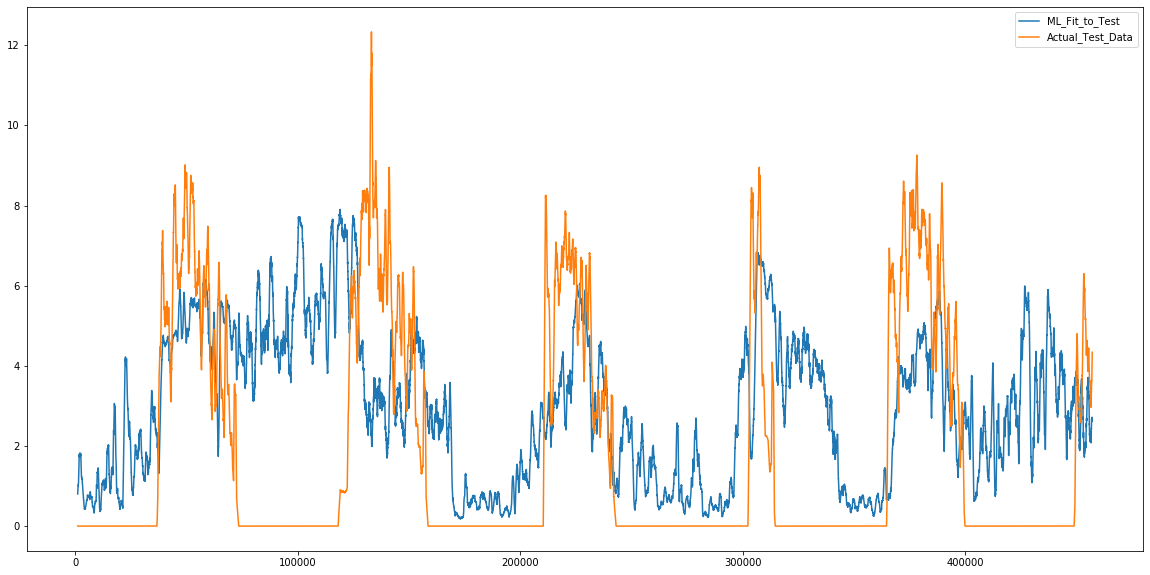

In [17]:
#PLOT PREDICTED VS OBSERVED
fig, ax = plt.subplots(figsize = (20,10))

ax.plot(comparison['m_dot(t)_fit'].rolling(1000).mean(),label='ML_Fit_to_Test')
ax.plot(comparison['m_dot(t)_test'].rolling(1000).mean(),label='Actual_Test_Data')
ax.legend()

# par1 = host.twinx()
# par1 = host.twiny()


# p1, = host.plot(yfit_roll, "b-", label="Predicted")
# p2, = par1.plot(y_test_roll, "r-", alpha = 0.7,label="Actual")

# host.set_xlabel("EPOCH TIME")
# host.set_ylabel("CO2")
# par1.set_ylabel("CO2")

# host.yaxis.label.set_color(p1.get_color())
# par1.yaxis.label.set_color(p2.get_color())

# tkw = dict(size=4, width=1.5)
# host.tick_params(axis='y', colors=p1.get_color(), **tkw)
# par1.tick_params(axis='y', colors=p2.get_color(), **tkw)
# host.tick_params(axis='x', **tkw)

# lines = [p1, p2]

# host.legend(lines, [l.get_label() for l in lines])

# plt.show()